*This post was entirely written using the IPython notebook. Its content is BSD-licensed. You can see a static view or download this notebook with the help of nbviewer at [20160830_SegmentingAnImageWithWatershed.ipynb](http://nbviewer.ipython.org/urls/raw.github.com/flothesof/posts/master/20160830_SegmentingAnImageWithWatershed.ipynb).*

This week, I've been watching the [Scipy 2016 tutorial for Scikit-image on YouTube](https://www.youtube.com/watch?v=TVALdmVJtAU). This tutorial has prompted me to write a little application of the technique of segmentation using the watershed algorithms. This post is essentially based on the material found on Github [here](https://github.com/scikit-image/skimage-tutorials/blob/master/lessons/4_segmentation.ipynb) and the official documentation for [scikit-image](http://scikit-image.org/).

# Goal of this post 

The goal of this post is to clearly explain the different steps used to provide a useful segmentation of an image using the watershed algorithm.

To this end, we're going to use an image from wikipedia dealing with one of my current interests: cuneiform tablets.

![tablet](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Tablet_with_Cuneiform_Inscription_LACMA_M.79.106.2_%284_of_4%29.jpg/800px-Tablet_with_Cuneiform_Inscription_LACMA_M.79.106.2_%284_of_4%29.jpg)

As one sees in the image above, there might be several steps involved before getting a clean image with signs in it:

- isolate the tablet from the background
- pick out individual cuneiform characters from the tablet
- threshold these to produce a final image

Let's get started!

# Loading the image

To work on the image, we first need to retrieve it as an array of pixels. Luckily for us, scikit-image allows you to download an image if you hand an url to the `imread` function:

In [1]:
from skimage import io

In [2]:
img = io.imread("https://upload.wikimedia.org/wikipedia/commons/thumb/f/f2/Tablet_with_Cuneiform_Inscription_LACMA_M.79.106.2_%284_of_4%29.jpg/800px-Tablet_with_Cuneiform_Inscription_LACMA_M.79.106.2_%284_of_4%29.jpg")

Let's check the properties of this image:

In [3]:
img.shape

(531, 800, 3)

It's a 531 by 800 pixels image with a rgb tuple defining the color of each pixel.

In [4]:
img.dtype

dtype('uint8')

The colors are defined by integers (values between 0 and 255), which we will convert to floats while working on them.

In [5]:
from skimage import img_as_float
img = img_as_float(img)

# Segmenting the background 

To cut out the background, we're going to apply the watershed algorithm while initializing the seeds for the algorithm with some foreground and some background pixels.

This works in the following way:

- create the seeds using a contour filter of the tablet image
- perform the segmentation

## Creating the seeds 

We first create a gray image, from which we will compute edges.

In [6]:
from skimage import color
gray = color.rgb2gray(img)

Let's display the gray image:

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] ='nearest'
plt.style.use('seaborn-muted')

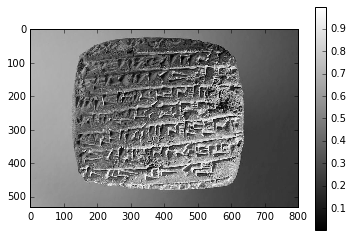

In [8]:
plt.imshow(gray)
plt.colorbar()

Now, we filter it using an edge filter.

In [9]:
from skimage import filters
elevation_map = filters.canny(gray)

C:\Anaconda3\lib\site-packages\skimage\filters\__init__.py:28: skimage_deprecation: Call to deprecated function ``canny``. Use ``skimage.feature.canny`` instead.
  def canny(*args, **kwargs):


Let's display this:

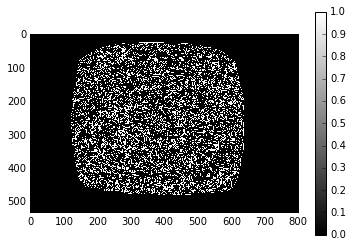

In [10]:
plt.imshow(elevation_map)
plt.colorbar()

The canny filter found some edges inside and outside the tablet. To really make the interior stick out, we average it using a gaussian filter:

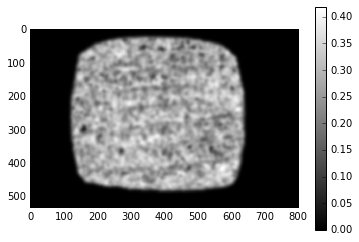

In [11]:
filled_elevation_map = filters.gaussian(elevation_map, sigma=5)
plt.imshow(filled_elevation_map)
plt.colorbar()

We now initialize the seeds by thresholding the previous image:

In [12]:
threshold = filters.threshold_otsu(filled_elevation_map)
threshold

0.13830405859398809

This allows us to make seeds for the background (1) and the tablet (2):

In [13]:
import numpy as np
seeds = np.zeros_like(gray)
seeds[filled_elevation_map < threshold / 5] = 1
seeds[filled_elevation_map > threshold] = 2

This yields three types of pixels:

- 0: to be assigned by the watershed algorihtm
- 1: background
- 2: foreground

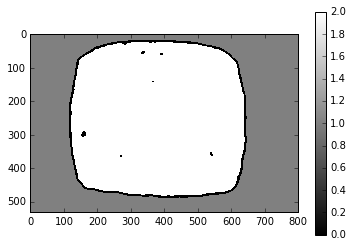

In [14]:
plt.imshow(seeds)
plt.colorbar()

## Performing the watershed 

Let's now flood the image:

In [15]:
from skimage.morphology import watershed
segmentation = watershed(filled_elevation_map, seeds)

What does the result look like?

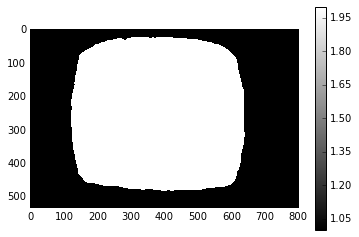

In [16]:
plt.imshow(segmentation)
plt.colorbar()

Great! We can recognize our tablet!

Finally, we can extract the tablet itself from the contour:

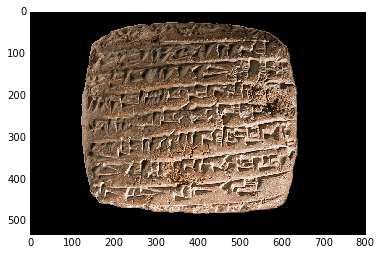

In [17]:
mask = (segmentation == 2).reshape(tuple([*segmentation.shape, 1]))
tablet = mask * img
plt.imshow(tablet)

# Cleaning the characters

Now that we have our tablet, we can start working on the characters itself. What assyriologist often do to work with tablets is to first produce a transcription such as this one:

![transcription](http://members.westnet.com.au/gary-david-thompson/Strassmaier_Drawing_2014-09-28_140428.jpg)

The transcription can be helpful for reading a tablet when it is not available anymore or quite simply to make a clearer picture of the signs, as tablets are difficult to read.

To obtain a sort of automated transcription, let's apply a local [histogram equalization](http://scikit-image.org/docs/dev/auto_examples/color_exposure/plot_local_equalize.html#sphx-glr-auto-examples-color-exposure-plot-local-equalize-py) to the tablet, to remove the artifacts from the lighting.

C:\Anaconda3\lib\site-packages\skimage\util\dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


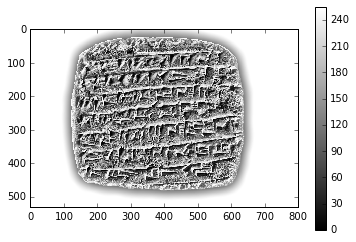

In [18]:
from skimage.morphology import disk
equalized = color.rgb2gray(tablet)
selem = disk(30)
equalized = filters.rank.equalize(equalized, selem=selem)
plt.imshow(equalized)
plt.colorbar()

Let's have a look at the resulting histogram:

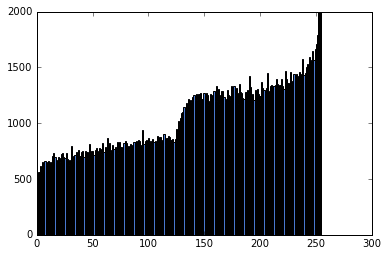

In [19]:
plt.hist(equalized.ravel(), bins=256);
plt.ylim(0, 2000);

Ideally, we would like to have some points at the bottom of the tablet and some at the surface and do the watershed on them.

In [20]:
seeds = np.zeros_like(equalized)
seeds[equalized < 10] = 1
seeds[(equalized > 140) & (equalized < 200)] = 2
seeds[(~mask[:, :, 0]).nonzero()] = 3

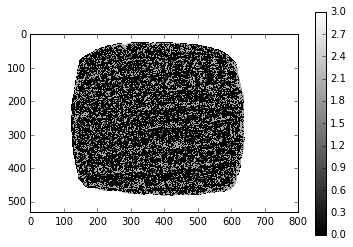

In [21]:
plt.imshow(seeds)
plt.colorbar()

In [22]:
edges = filters.sobel(equalized)

In [23]:
ws = watershed(edges, seeds)

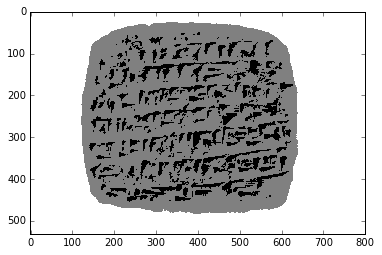

In [24]:
plt.imshow(ws)

Finally, we can produce our cleaned image and compare it to the original:

In [25]:
import scipy.ndimage as ndi
cleaned = np.ones_like(ws)
# signs
cleaned[(ws == 1)] = 0
cleaned = ndi.binary_opening(cleaned)
# border of tablet
cleaned[filters.canny(mask[:, :, 0]) == 1] = 0

C:\Anaconda3\lib\site-packages\skimage\filters\__init__.py:28: skimage_deprecation: Call to deprecated function ``canny``. Use ``skimage.feature.canny`` instead.
  def canny(*args, **kwargs):


Let's compare both images in full size:

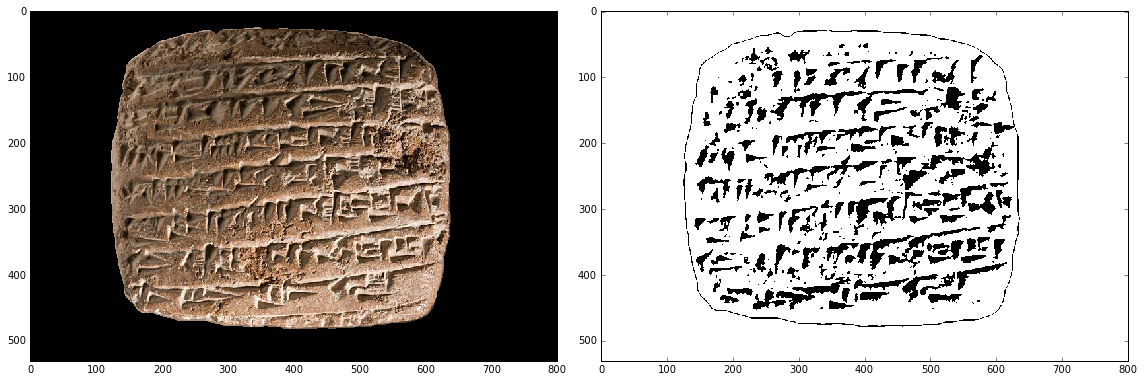

In [26]:
fig, ax = plt.subplots(1, 2, figsize=(16, 10))
ax[0].imshow(tablet)
ax[1].imshow(cleaned)
plt.tight_layout()

We can also apply some zoom on this:

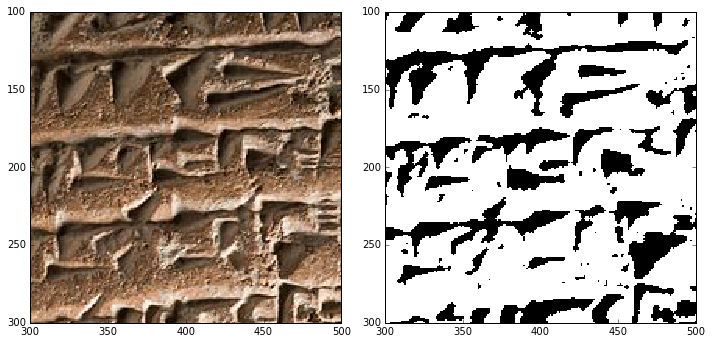

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

zoom = lambda ax: ax.set_xlim(300, 500) and ax.set_ylim(300, 100)
ax[0].imshow(tablet)
zoom(ax[0])
ax[1].imshow(cleaned)
zoom(ax[1])
plt.tight_layout()

# Conclusions 

In this blogpost, we've manipulated a couple of standard image segmentation algorithms using scikit-image. We've applied it to a cuneiform tablet inscription available on wikipedia and obtained a simplified representation from it, essentially applying the watershed algorithm to it. 

Further work ideas are numerous here: the final image, although meant to simplifiy the analysis of the original tablet which is difficult due to lighting issues, does reach this goal. So the question is: would it be possible to single out each sign and perform a more accurate automatic transcription? 